In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import ast
import numpy as np
import os
import re

from fit_runtimes import compute_best_fit

In [3]:
megatron_name_to_crfm_name_mapping = {
    "gptj_6b": ["huggingface/gptj_6b", "gooseai/gpt-j-6b", "together/gpt-j-6b"],
    "gpt_neox_20b": ["gooseai/gpt-neo-20b", "together/gpt-neox-20b"],
    "openai_ada": ["openai/ada"],
    "openai_davinci": ["openai/davinci", "together/opt-175b"],
    "openai_text-davinci-001": ["openai/text-davinci-001"],
    "openai_text-davinci-002": ["openai/text-davinci-002"],
    "ai21_j1_large": ["ai21/j1-large", "openai/curie", "microsoft/TNLGv2_7B"],
    "ai21_j1_grande": ["ai21/j1-grande"],
    "ai21_j1_jumbo": ["ai21/j1-jumbo"],
    "gpt2": ["huggingface/gpt2"],
    "mt_nlg": ["microsoft/TNLGv2_530B"],
    "anthropic": ["anthropic/stanford-online-all-v4-s3"],
    "bloom": ["together/bloom"],
    "opt_66b": ["together/opt-66b"],
    "yalm": ["together/yalm"],
}

crfm_name_to_megatron_name_mapping = {}
for megatron_name in megatron_name_to_crfm_name_mapping:
    crfm_names = megatron_name_to_crfm_name_mapping[megatron_name]
    crfm_name = crfm_names[0]
    crfm_name_to_megatron_name_mapping[
        crfm_name.replace("/", "_")] = megatron_name
crfm_name_to_megatron_name_mapping["together_opt-175b"] = "opt_175b"
crfm_name_to_megatron_name_mapping["together_gpt-neo-20b"] = "together_gpt_neox_20b"
crfm_name_to_megatron_name_mapping["together_gpt-j-6b"] = "together_gptj_6b"
crfm_name_to_megatron_name_mapping["openai_text-curie-001"] = "openai_curie"

# Read runtimes from logfiles

In [4]:
def read_megatron_runtimes(logfile_directory):
    runtimes = {}
    for logfile_name in os.listdir(logfile_directory):
        model = logfile_name.replace(".log", "")
        logfile_full_path = os.path.join(logfile_directory, logfile_name)
        with open(logfile_full_path, 'r') as f:
            for line in f:
                m = re.match(r'Runtime for (.*): (\d+\.\d+) seconds', line)
                if m is not None:
                    label = ast.literal_eval(m.group(1))
                    label['model'] = model
                    runtime = float(m.group(2))
                    # Account for the fact that we only profiled 1/3rd of the layers
                    # in the Megatron-Turing NLG model.
                    if model == "mt_nlg":
                        runtime *= 3
                    runtimes[(label['model'], label['num_input_tokens'],
                              label['num_output_tokens'])] = runtime
    return runtimes

In [5]:
megatron_runtimes = read_megatron_runtimes("../logs/a100")

In [6]:
import json
def read_real_system_runtimes(parent_dir):
    all_runtimes = {}
    for sub_dir in os.listdir(parent_dir):
        m = re.match(r'synthetic_efficiency:.*,num_input_tokens=(\d+),'
                     r'num_output_tokens=(\d+),.*,model=(.*)', sub_dir)
        if m is not None:
            num_prompt_tokens = int(m.group(1))
            num_output_tokens = int(m.group(2))
            model = crfm_name_to_megatron_name_mapping.get(m.group(3), m.group(3))
            
            full_logpath = os.path.join(parent_dir, sub_dir, "per_instance_stats.json")
            try:
                with open(full_logpath, 'r') as f:
                    metrics = json.load(f)
                    runtimes = []
                    for instance, metrics in metrics.items():
                        runtime = None
                        num_output_tokens_in_per_instance_metrics = None
                        for metric in metrics:
                            if metric["name"]["name"] == "inference_runtime":
                                runtime = metric["values"][0]
                            if metric["name"]["name"] == "num_output_tokens":
                                num_output_tokens_in_per_instance_metrics = metric["values"][0]
                        if num_output_tokens_in_per_instance_metrics == num_output_tokens:
                            if runtime is not None:
                                runtimes.append(runtime)
                    if (model, num_prompt_tokens, num_output_tokens) in all_runtimes:
                        min_runtime = all_runtimes[(model, num_prompt_tokens, num_output_tokens)]
                        all_runtimes[(model, num_prompt_tokens, num_output_tokens)] = \
                            min(min_runtime, min(runtimes))
                    else:
                        all_runtimes[(model, num_prompt_tokens, num_output_tokens)] = min(runtimes)
            except:
                pass
        
    return all_runtimes

In [7]:
real_system_runtimes = read_real_system_runtimes("../benchmark_output/runs/latest")

# Plot runtimes versus number of output tokens to verify linearity

In [8]:
def plot_per_model_runtimes(runtimes, model, all_num_prompt_tokens,
                            scatter=False,
                            model_obj=None,
                            ylabel=None,
                            output_filename=None):
    print(model)

    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    markers = ['+', 'D', 's', 'o', '^']
    for marker, num_prompt_tokens in zip(markers, all_num_prompt_tokens):
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_prompt_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
        num_output_tokens_and_runtimes.sort()
        if scatter:
            ax.scatter([x for (x, _) in num_output_tokens_and_runtimes],
                       [y for (_, y) in num_output_tokens_and_runtimes],
                       label=f"{num_prompt_tokens}",
                       marker=marker)
            if model_obj is not None:
                runtime_per_output_token = model_obj["runtime_per_output_token"]
                intercept = model_obj["runtime_for_prompt_tokens"][num_prompt_tokens]
                if "overhead" in model_obj:
                    intercept += model_obj["overhead"]
                ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                        [intercept + ((x - 1) * runtime_per_output_token)
                         for (x, _) in num_output_tokens_and_runtimes], linestyle=':')
        else:
            ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                    [y for (_, y) in num_output_tokens_and_runtimes],
                    label=f"{num_prompt_tokens}",
                    marker='o')
            
    ax.set_xticks([1, 4, 8, 16, 32, 48, 64])
    
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel("Number of output tokens")
    if ylabel is None:
        ax.set_ylabel("Runtime (seconds)")
    else:
        ax.set_ylabel(ylabel)
    plt.legend(frameon=False, ncol=2)
    sns.despine()
    
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    
    plt.show()

# Get best-fit lines (slope and intercept)

In [9]:
# Compute best fit for A100 runtimes.
megatron_models = ["openai_ada", "openai_davinci", "ai21_j1_large", "ai21_j1_jumbo",
                   "gptj_6b", "gpt_neox_20b", "mt_nlg", "anthropic", "bloom",
                   "opt_66b", "yalm"]
real_system_models = ["ai21_j1_large", "ai21_j1_grande", "ai21_j1_jumbo", "anthropic",
                      "openai_davinci", "openai_text-davinci-001", "openai_text-davinci-002"]
megatron_json_obj = \
    compute_best_fit(megatron_runtimes, megatron_models,
                     megatron_name_to_crfm_name_mapping,
                     estimate_runtime_for_prompt_tokens=True,
                     filename="../processed_jsons/inference_idealized_runtimes.json")
real_system_json_obj = \
    compute_best_fit(real_system_runtimes, real_system_models,
                     megatron_name_to_crfm_name_mapping,
                     estimate_runtime_for_prompt_tokens=True,
                     real_system=True,
                     filename="../processed_jsons/inference_denoised_runtimes.json")

R^2 score: 1.000
openai_ada:
	Runtime per output token = 0.019 seconds
	Overhead: 0.002 seconds
	Runtime for 1 prompt token(s) = 0.021 seconds
	Runtime for 16 prompt token(s) = 0.022 seconds
	Runtime for 32 prompt token(s) = 0.021 seconds
	Runtime for 64 prompt token(s) = 0.021 seconds
	Runtime for 128 prompt token(s) = 0.021 seconds
	Runtime for 192 prompt token(s) = 0.022 seconds
	Runtime for 256 prompt token(s) = 0.022 seconds
	Runtime for 320 prompt token(s) = 0.023 seconds
	Runtime for 384 prompt token(s) = 0.024 seconds
	Runtime for 428 prompt token(s) = 0.025 seconds
	Runtime for 472 prompt token(s) = 0.025 seconds
	Runtime for 512 prompt token(s) = 0.025 seconds
	Runtime for 576 prompt token(s) = 0.025 seconds
	Runtime for 640 prompt token(s) = 0.026 seconds
	Runtime for 704 prompt token(s) = 0.027 seconds
	Runtime for 768 prompt token(s) = 0.027 seconds
	Runtime for 832 prompt token(s) = 0.028 seconds
	Runtime for 896 prompt token(s) = 0.028 seconds
	Runtime for 960 prompt tok

	Mean squared error: 0.0002
	Maximum squared error: 0.0117

R^2 score: 1.000
opt_66b:
	Runtime per output token = 0.055 seconds
	Overhead: 0.001 seconds
	Runtime for 1 prompt token(s) = 0.056 seconds
	Runtime for 16 prompt token(s) = 0.060 seconds
	Runtime for 32 prompt token(s) = 0.060 seconds
	Runtime for 64 prompt token(s) = 0.062 seconds
	Runtime for 128 prompt token(s) = 0.064 seconds
	Runtime for 192 prompt token(s) = 0.065 seconds
	Runtime for 256 prompt token(s) = 0.074 seconds
	Runtime for 320 prompt token(s) = 0.092 seconds
	Runtime for 384 prompt token(s) = 0.097 seconds
	Runtime for 428 prompt token(s) = 0.122 seconds
	Runtime for 472 prompt token(s) = 0.122 seconds
	Runtime for 512 prompt token(s) = 0.126 seconds
	Runtime for 576 prompt token(s) = 0.150 seconds
	Runtime for 640 prompt token(s) = 0.152 seconds
	Runtime for 704 prompt token(s) = 0.178 seconds
	Runtime for 768 prompt token(s) = 0.184 seconds
	Runtime for 832 prompt token(s) = 0.212 seconds
	Runtime for 896 pr

openai_davinci


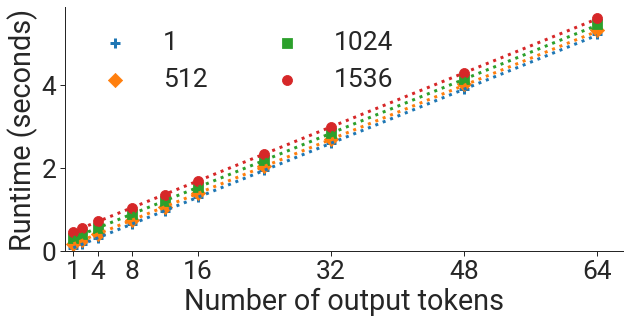

ai21_j1_jumbo


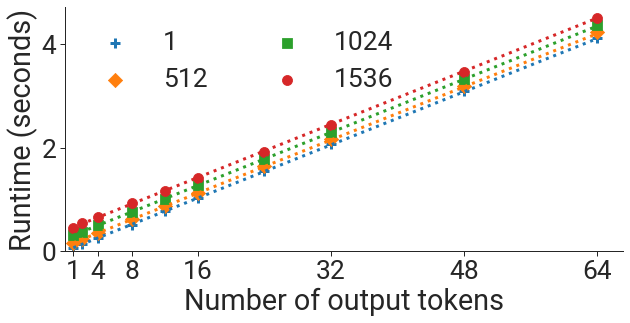

mt_nlg


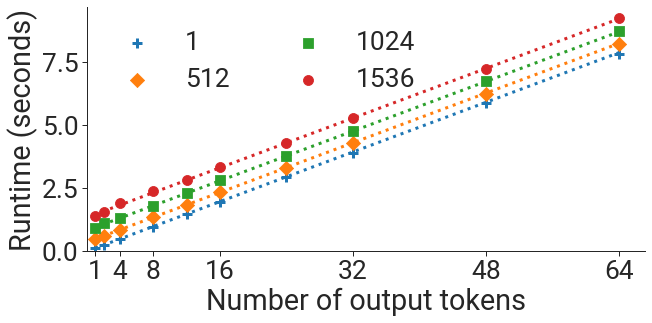

anthropic


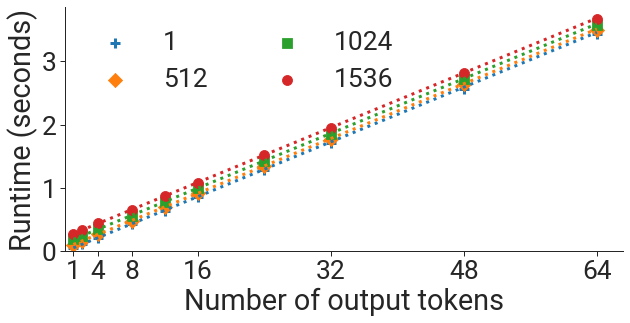

bloom


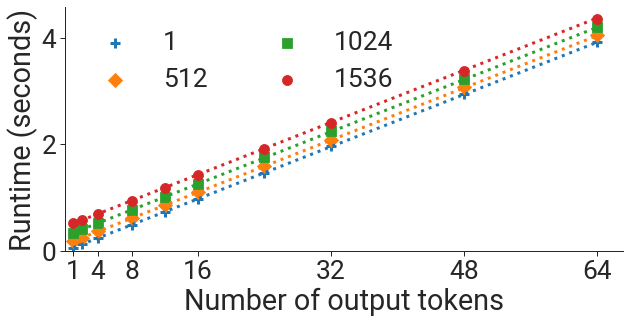

opt_66b


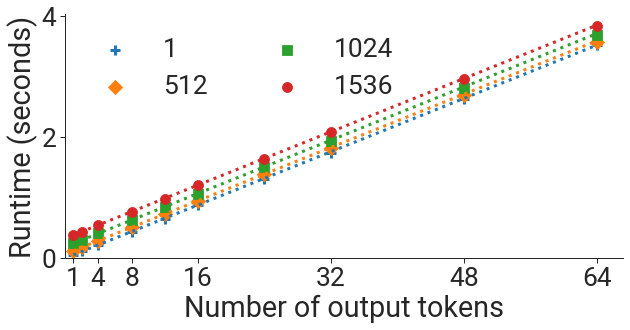

yalm


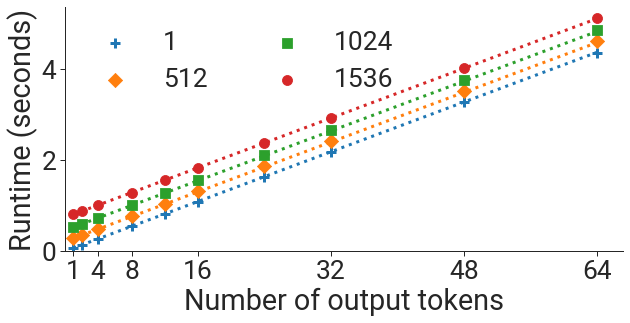

In [10]:
# Plot A100 runtimes on Megatron.
runtimes = megatron_runtimes
plot_per_model_runtimes(runtimes, 'openai_davinci', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["openai/davinci"],
                        output_filename='../figures/runtime_vs_num_output_tokens/openai_davinci.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_jumbo', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["ai21/j1-jumbo"],
                        output_filename='../figures/runtime_vs_num_output_tokens/ai21_j1_jumbo.pdf')
plot_per_model_runtimes(runtimes, 'mt_nlg', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["microsoft/TNLGv2_530B"],
                        output_filename='../figures/runtime_vs_num_output_tokens/mt_nlg.pdf')
plot_per_model_runtimes(runtimes, 'anthropic', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["anthropic/stanford-online-all-v4-s3"],
                        output_filename='../figures/runtime_vs_num_output_tokens/anthropic.pdf')
plot_per_model_runtimes(runtimes, 'bloom', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["together/bloom"],
                        output_filename='../figures/runtime_vs_num_output_tokens/bloom.pdf')
plot_per_model_runtimes(runtimes, 'opt_66b', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["together/opt-66b"],
                        output_filename='../figures/runtime_vs_num_output_tokens/opt_66b.pdf')
plot_per_model_runtimes(runtimes, 'yalm', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["together/yalm"],
                        output_filename='../figures/runtime_vs_num_output_tokens/yalm.pdf')

ai21_j1_large


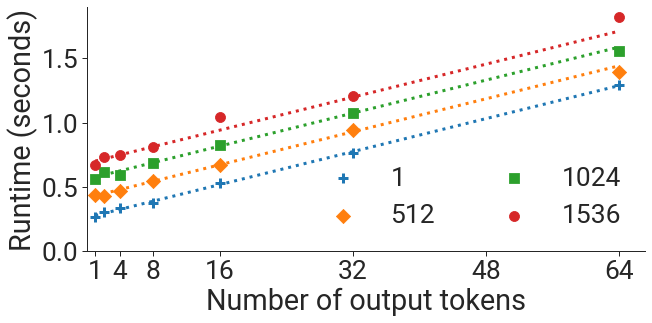

ai21_j1_grande


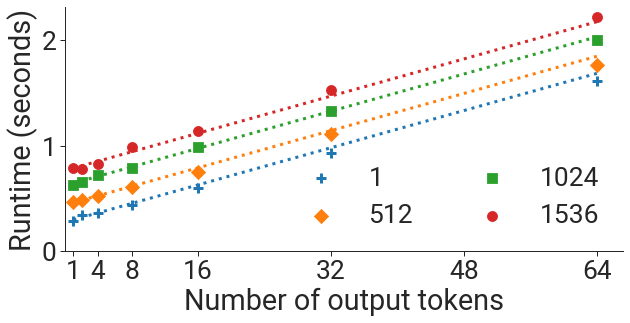

ai21_j1_jumbo


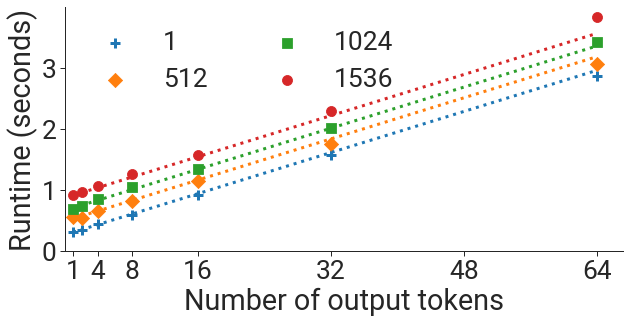

anthropic


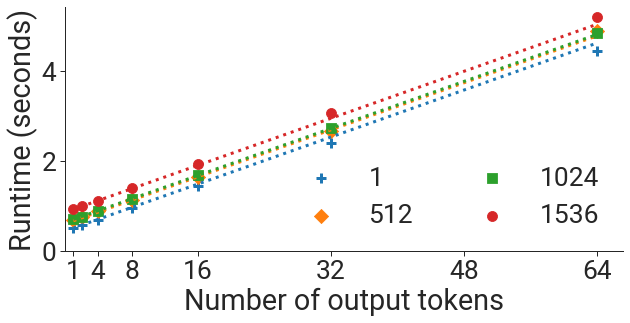

openai_davinci


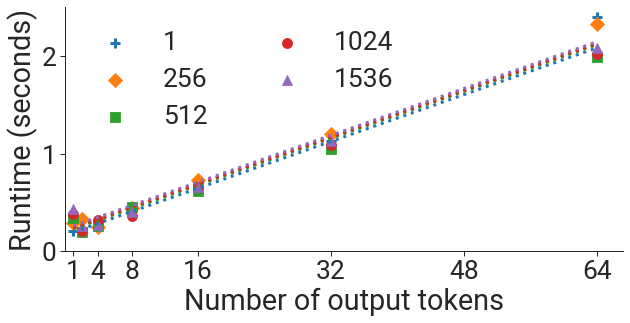

openai_text-davinci-001


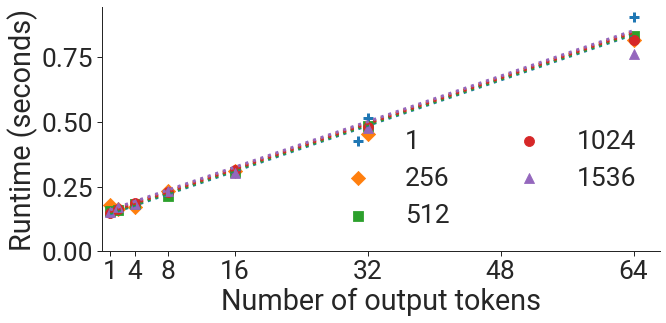

openai_text-davinci-002


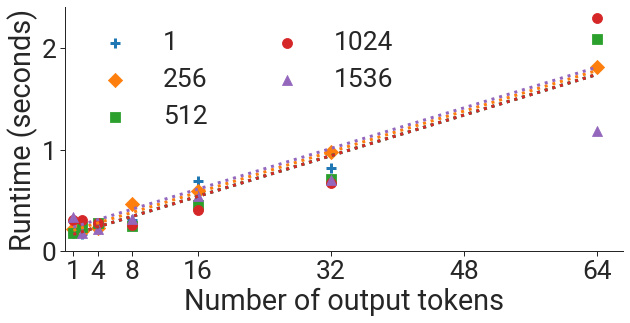

In [11]:
# Plot minimum black-box API runtimes.
runtimes = real_system_runtimes
plot_per_model_runtimes(runtimes, 'ai21_j1_large', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["ai21/j1-large"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_large_v3.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_grande', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["ai21/j1-grande"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_grande_v3.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_jumbo', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["ai21/j1-jumbo"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_jumbo_v3.pdf')
plot_per_model_runtimes(runtimes, 'anthropic', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["anthropic/stanford-online-all-v4-s3"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_anthropic_v3.pdf')
plot_per_model_runtimes(runtimes, 'openai_davinci', [1, 256, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["openai/davinci"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_openai_davinci_v3.pdf')
plot_per_model_runtimes(runtimes, 'openai_text-davinci-001', [1, 256, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["openai/text-davinci-001"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_openai_text-davinci-001_v3.pdf')
plot_per_model_runtimes(runtimes, 'openai_text-davinci-002', [1, 256, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["openai/text-davinci-002"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_openai_text-davinci-002_v3.pdf')